# Reliability anaysis


## Packages and Helpers

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [2]:
# load overall df
all_data = pd.read_csv("processed_data/divided_items_per_LLM.csv")

## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [4]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # Normalize score_top_n
        data.loc[mask, "score_top_n"] = (
            data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)


## Chronbach's Alpha

In [7]:
def compute_cronbach_alpha(score="score"):

    results = []

    # loop through experiments
    for exp, exp_data in all_data.groupby("experiment"):

        #
        # LOOP THROUGH FLIPPED AND REVERSE-CODED SUBSETS
        #
        for flipped_val, flipped_data in exp_data.groupby("flipped"):
            for rc_val, rc_data in flipped_data.groupby("reverse_coded"):

                # check whether experiment has domains / categories
                if rc_data["category"].notna().any() and exp != "SOEP scale":

                    # compute alpha per domain
                    for domain, domain_data in rc_data.groupby("category"):

                        df_wide = domain_data.pivot_table(
                            index="model",
                            columns="item",
                            values=score
                        )

                        if df_wide.shape[1] > 1:
                            alpha, ci = pg.cronbach_alpha(df_wide)
                        else:
                            alpha, ci = None, (None, None)

                        results.append({
                            "experiment": exp,
                            "domain": domain,
                            "flipped": flipped_val,
                            "reverse_coded": rc_val,
                            "alpha": alpha,
                            "alpha_CI": ci
                        })

                else:
                    # compute alpha for whole experiment
                    df_wide = rc_data.pivot_table(
                        index="model",
                        columns="item",
                        values=score
                    )

                    if df_wide.shape[1] > 1:
                        alpha, ci = pg.cronbach_alpha(df_wide)
                    else:
                        alpha, ci = None, (None, None)

                    results.append({
                        "experiment": exp,
                        "domain": "total",
                        "flipped": flipped_val,
                        "reverse_coded": rc_val,
                        "alpha": alpha,
                        "alpha_CI": ci
                    })

    return pd.DataFrame(results)


In [15]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()


# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_top_n_df = compute_cronbach_alpha(score = "score_top_n")


# Merge only selected columns
alpha_df = alpha_df.merge(
    alpha_top_n_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_total", "_top_n")
)

display(alpha_df.tail(50))

,experiment,domain,flipped_total,reverse_coded_total,alpha_total,alpha_CI_total,flipped_top_n,reverse_coded_top_n,alpha_top_n,alpha_CI_top_n
98,SSSV scale,SStas,False,False,0.971854,"[0.957, 0.983]",True,False,0.963135,"[0.943, 0.978]"
99,SSSV scale,SStas,False,False,0.971854,"[0.957, 0.983]",True,True,0.921173,"[0.878, 0.952]"
100,SSSV scale,SSbor,False,True,0.962314,"[0.942, 0.977]",False,False,0.787880,"[0.673, 0.871]"
101,SSSV scale,SSbor,False,True,0.962314,"[0.942, 0.977]",False,True,0.841407,"[0.755, 0.904]"
102,SSSV scale,SSbor,False,True,0.962314,"[0.942, 0.977]",True,False,0.877469,"[0.811, 0.926]"
103,SSSV scale,SSbor,False,True,0.962314,"[0.942, 0.977]",True,True,0.935362,"[0.9, 0.961]"
104,SSSV scale,SSdis,False,True,0.808771,"[0.699, 0.885]",False,False,0.887859,"[0.829, 0.931]"
105,SSSV scale,SSdis,False,True,0.808771,"[0.699, 0.885]",False,True,0.714503,"[0.551, 0.829]"
106,SSSV scale,SSdis,False,True,0.808771,"[0.699, 0.885]",True,False,0.960128,"[0.939, 0.976]"
107,SSSV scale,SSdis,False,True,0.808771,"[0.699, 0.885]",True,True,0.758443,"[0.62, 0.855]"


## Split-half Reliability

In [10]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [11]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [12]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.686231,0.149443
1,BARRAT scale,BISa,0.911893,0.038829
2,BARRAT scale,BISm,0.878682,0.061749
3,BARRAT scale,BISn,0.801819,0.127873
4,BART task,total,0.989346,0.004453
5,CARE scale,CAREa,0.990002,0.010342
6,CARE scale,CAREs,0.976353,0.020465
7,CARE scale,CAREw,0.996216,0.000752
8,CCT task,total,0.994622,0.002822
9,DAST scale,total,0.944955,0.019109


## Visualize Distributions per model

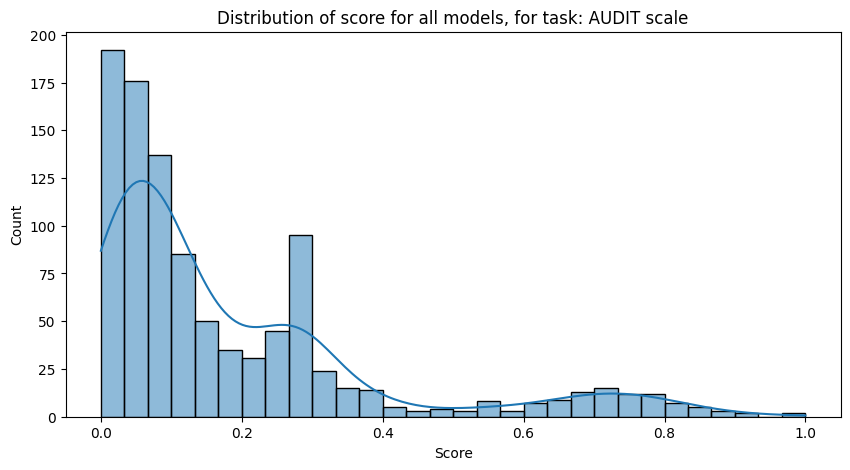

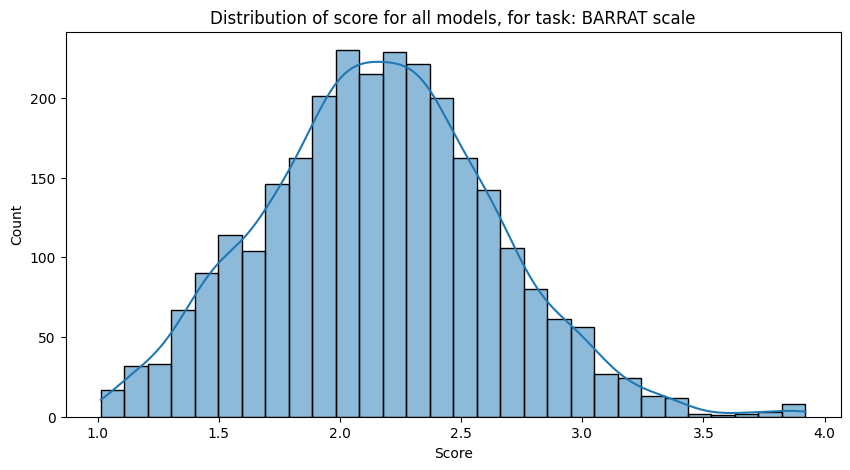

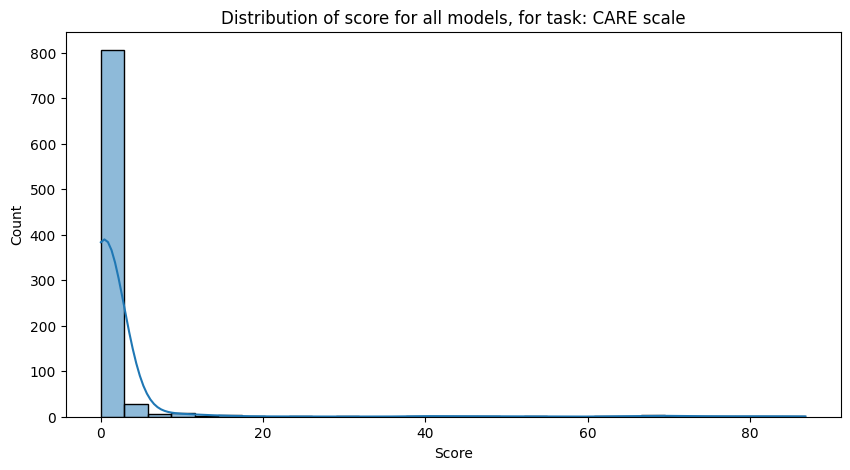

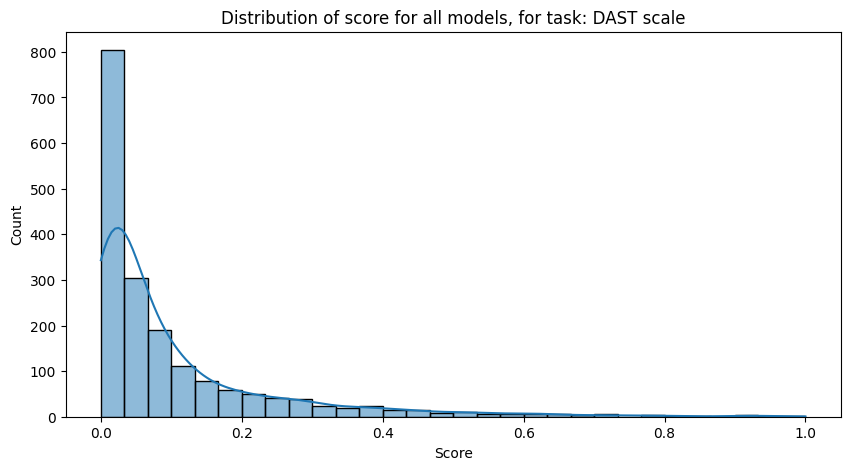

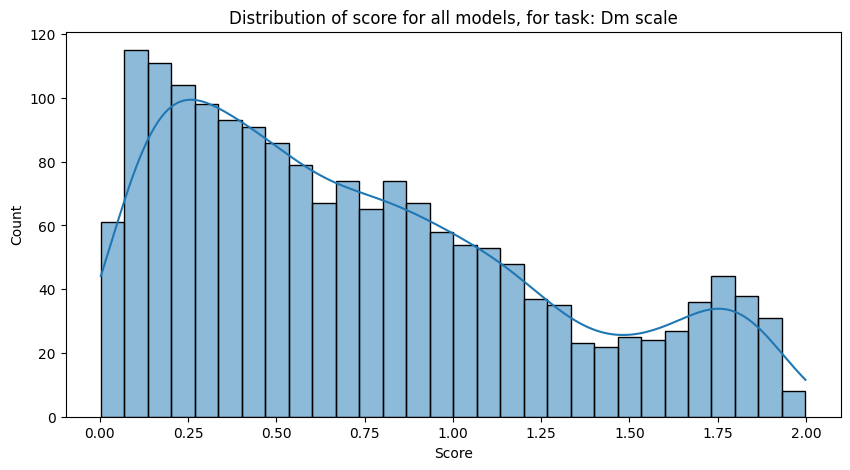

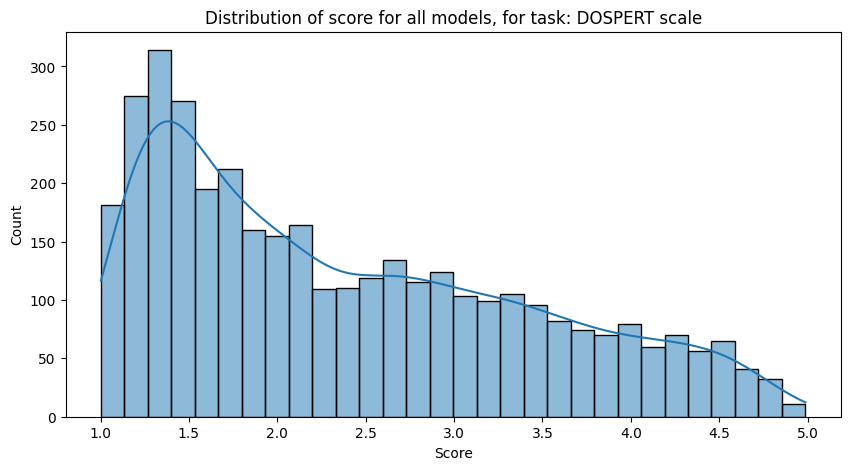

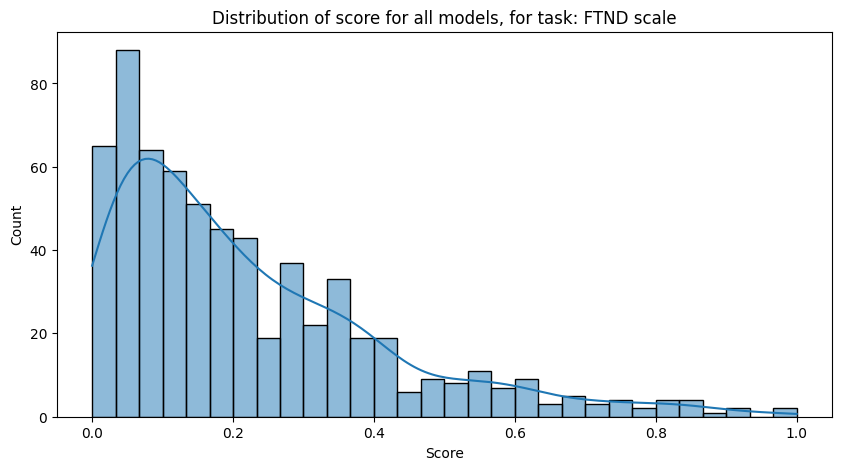

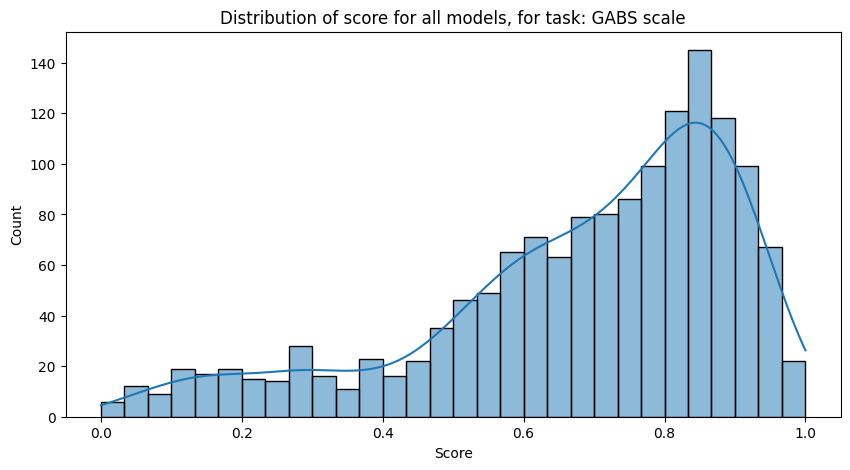

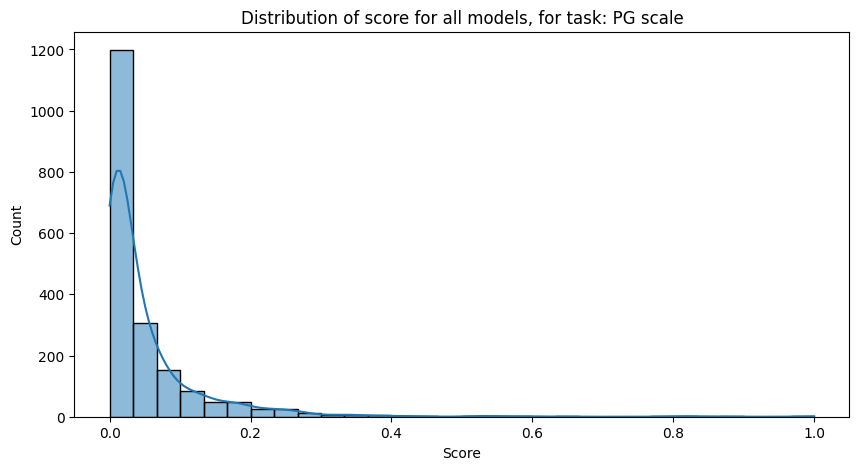

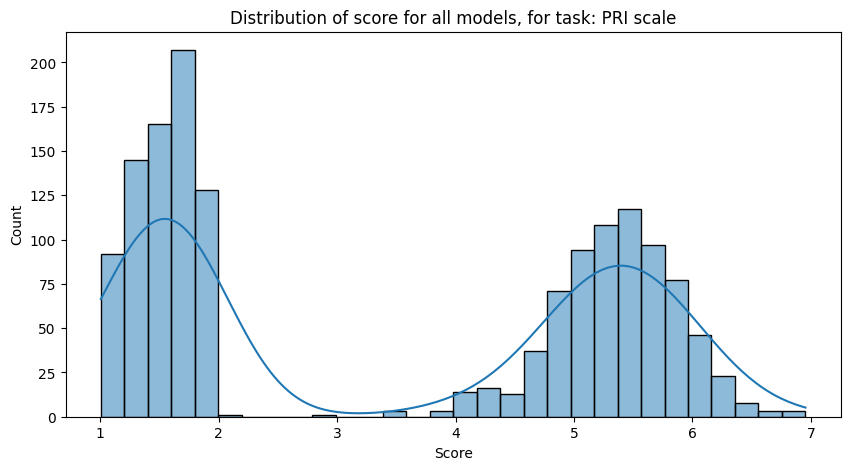

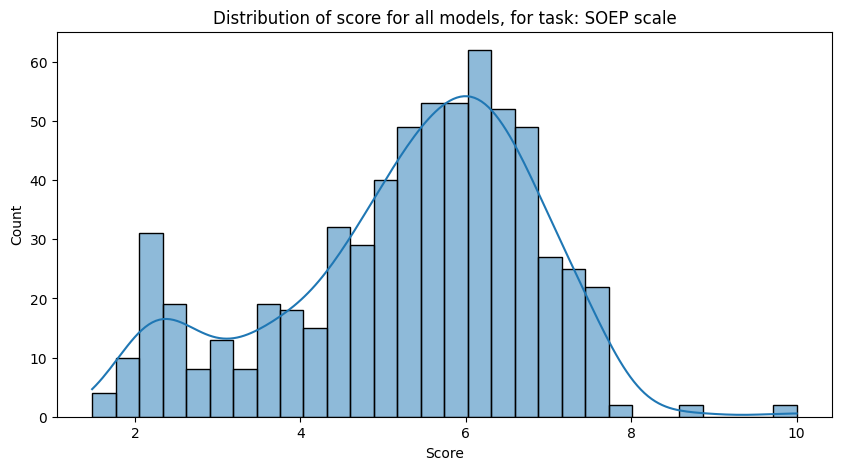

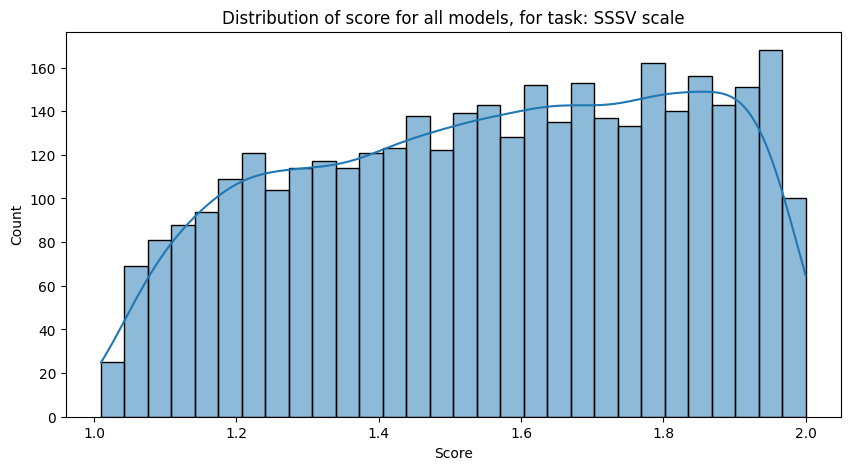

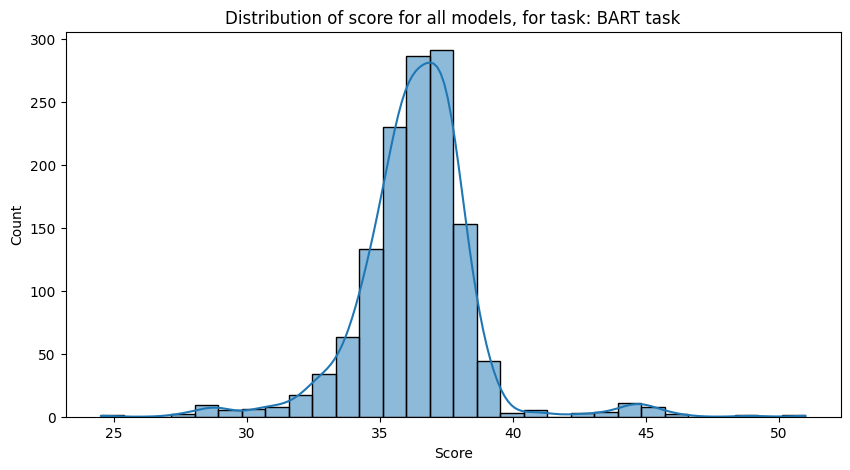

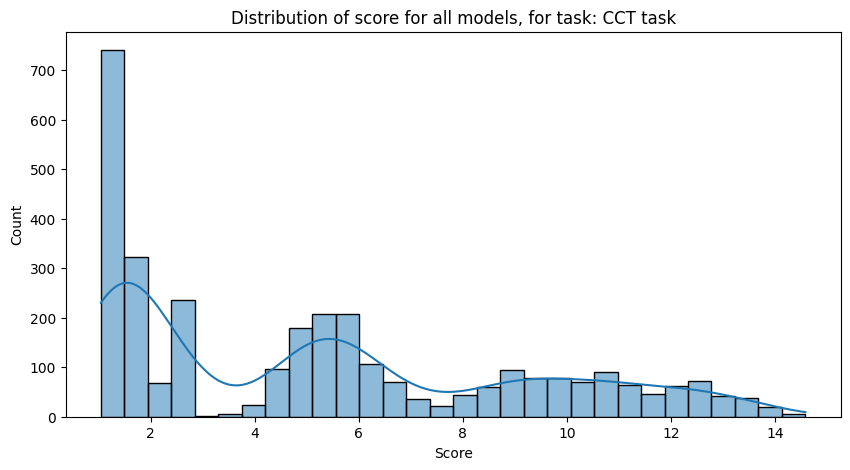

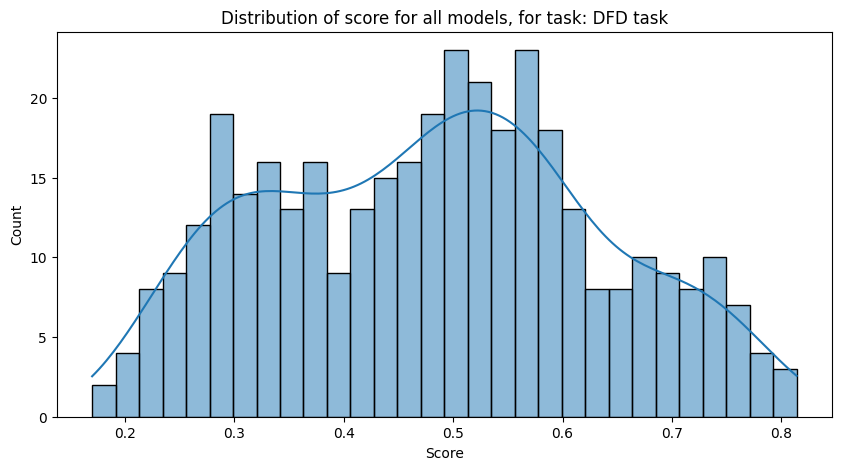

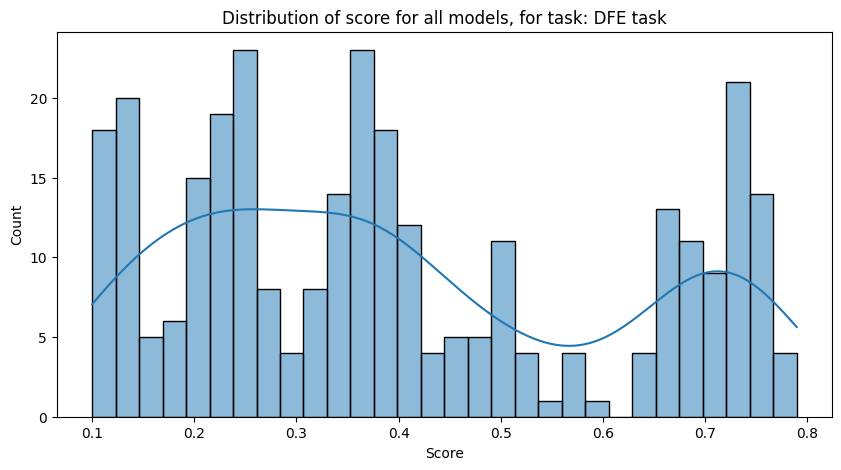

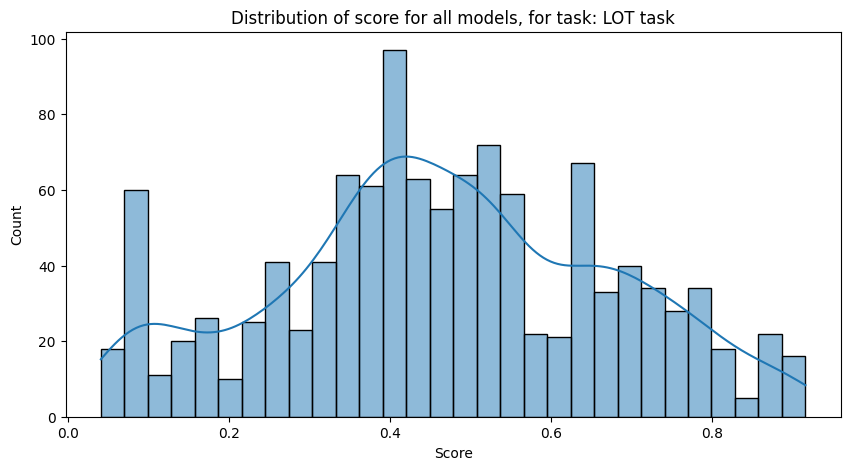

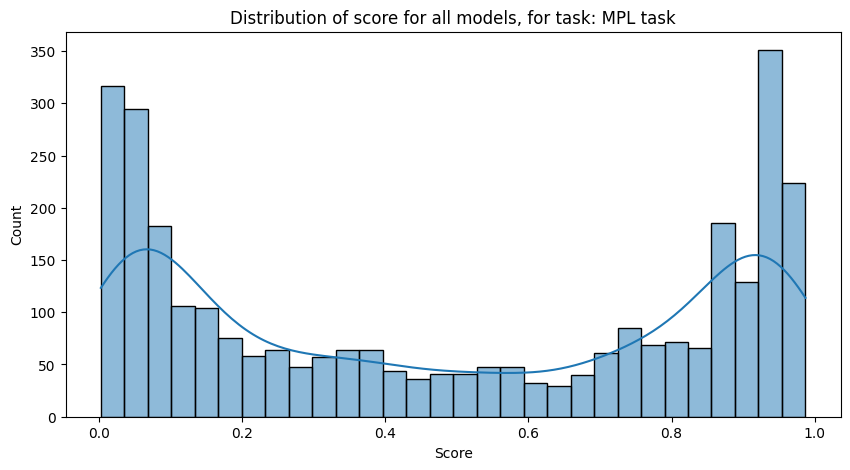

In [13]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()